<a href="https://colab.research.google.com/github/watchback/CSB_hanjin/blob/main/ai/%EA%B4%91%EC%96%B4_%EB%94%A5%EB%9F%AC%EB%8B%9D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
from  tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  tensorflow.keras.preprocessing import image

In [ ]:
base_path = '/content/drive/MyDrive/gwanger'

train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
path = os.path.join(base_path, 'train')

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.1, stratify=train_df['label'])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)


In [ ]:
cls = lambda x : os.path.join(path, '_'.join(x.split('_')[1:-1])+'/'+x)
train['image'] = train['image'].map(lambda x : cls(x))
train.head(10)

,image,label
0,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
1,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
2,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
3,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
4,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
5,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
6,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
7,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
8,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
9,/content/drive/MyDrive/gwanger/train/normal/_n...,normal


In [ ]:
valid['image'] = valid['image'].map(lambda x : cls(x))
valid.head(10)

,image,label
0,/content/drive/MyDrive/gwanger/train/normal/_n...,normal
1,/content/drive/MyDrive/gwanger/train/normal/_n...,normal
2,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
3,/content/drive/MyDrive/gwanger/train/normal/_n...,normal
4,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
5,/content/drive/MyDrive/gwanger/train/normal/_n...,normal
6,/content/drive/MyDrive/gwanger/train/normal/_n...,normal
7,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
8,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus
9,/content/drive/MyDrive/gwanger/train/virus/_vi...,virus


In [ ]:
# 데이터 증강

height, width, channel = (299, 299, 3)
batch_size = 32
labels = train.label.unique().tolist()

train_datagen= ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              zoom_range=[0.7, 1],
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = './train',
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))


valid_datagen = ImageDataGenerator(rescale=1. / 255.)

valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                   directory = './train',
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

Found 102 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


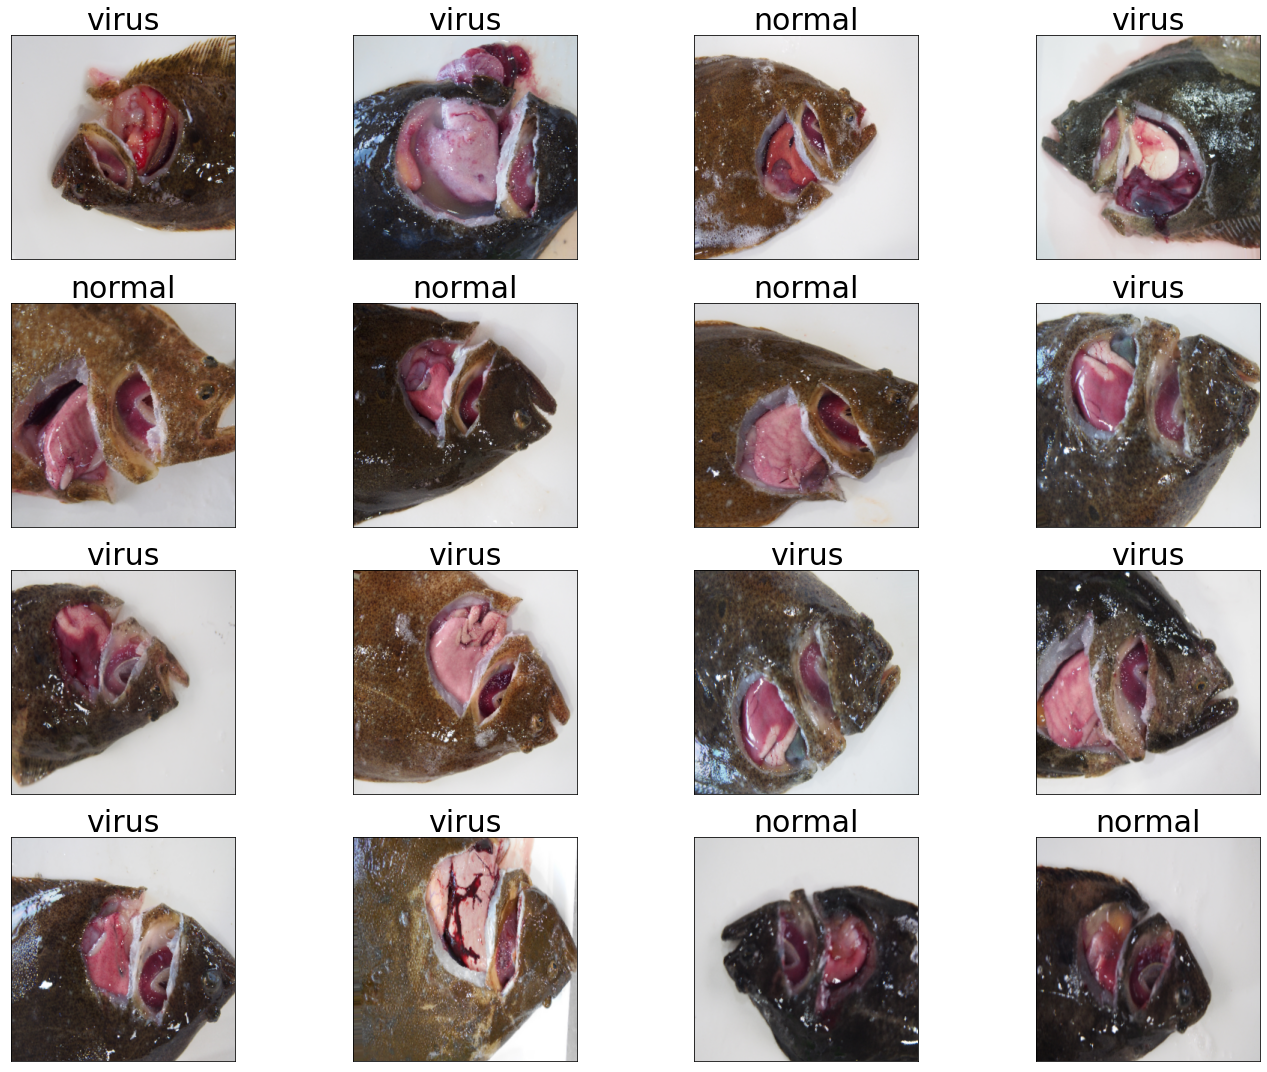

In [ ]:
pred2label={}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x


plt.figure(figsize=(20,15))
index = np.random.randint(len(train_df), size=batch_size)
x_augs, y_augs = train_generator.next()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_augs[i, :, :, :])
    plt.title(pred2label[np.argmax(y_augs[i, :])], fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()

In [1]:
import tensorflow
import numpy as np
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Resizing
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
base_model=keras.applications.xception.Xception(weights='imagenet',include_top=False)
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output=keras.layers.Dense(2,activation='softmax')(avg)
model=keras.Model(inputs=base_model.input,outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
optimizer=keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'best_model.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)
callbacks=[cb_checkpoint]
model.compile(loss='binary_crossentropy',optimizer=optimizer,
              metrics=['accuracy'])
history=model.fit(train_generator,epochs=15,validation_data=valid_generator,callbacks=callbacks)

Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.6078
Epoch 1: val_loss improved from inf to 0.66828, saving model to ./model/best_model.hdf5
4/4 [==============================] - 65s 12s/step - loss: 0.6816 - accuracy: 0.6078 - val_loss: 0.6683 - val_accuracy: 0.5833
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5882
Epoch 2: val_loss improved from 0.66828 to 0.60006, saving model to ./model/best_model.hdf5
4/4 [==============================] - 26s 6s/step - loss: 0.6922 - accuracy: 0.5882 - val_loss: 0.6001 - val_accuracy: 0.7500
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7745
Epoch 3: val_loss improved from 0.60006 to 0.59768, saving model to ./model/best_model.hdf5
4/4 [==============================] - 27s 9s/step - loss: 0.4589 - accuracy: 0.7745 - val_loss: 0.5977 - val_accuracy: 0.7500
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.47

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

model = load_model('/content/model/best_model.hdf5')
for layer in base_model.layers:
  layer.trainable=True

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)
callbacks=[cb_checkpoint]
optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,
              metrics=['accuracy'])
history=model.fit(train_generator,epochs=35,validation_data=valid_generator,callbacks=callbacks)

Epoch 1/35
4/4 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8725
Epoch 1: val_loss improved from inf to 0.46466, saving model to ./model/01-0.4647.hdf5
4/4 [==============================] - 32s 9s/step - loss: 0.3204 - accuracy: 0.8725 - val_loss: 0.4647 - val_accuracy: 0.8333
Epoch 2/35
4/4 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9118
Epoch 2: val_loss improved from 0.46466 to 0.44929, saving model to ./model/02-0.4493.hdf5
4/4 [==============================] - 26s 8s/step - loss: 0.2627 - accuracy: 0.9118 - val_loss: 0.4493 - val_accuracy: 0.7500
Epoch 3/35
4/4 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8431
Epoch 3: val_loss did not improve from 0.44929
4/4 [==============================] - 25s 6s/step - loss: 0.3251 - accuracy: 0.8431 - val_loss: 0.4922 - val_accuracy: 0.7500
Epoch 4/35
4/4 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8627
Epoch 4: val_loss did not 

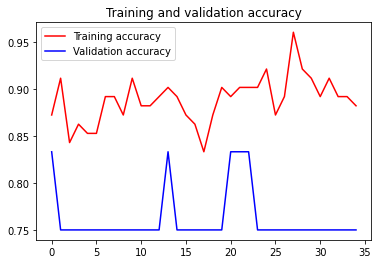

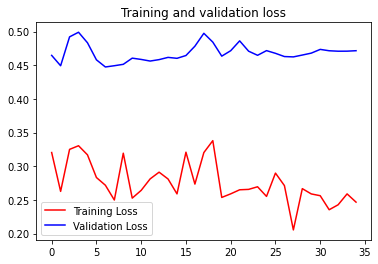

In [ ]:
# 정확도와 손실값 확인

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_df = pd.read_csv(os.path.join(base_path, "submission.csv"))

In [ ]:
batch_size = len(test_df["image"])
height, width, channel = 299, 299, 3

In [ ]:
path =  os.path.join(base_path, 'test')

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)
cnt=0
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(path,path_img), target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor,dtype="float32")

    img_tensor /= 255
    
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    test_image[i] = img_tensor

(10, 299, 299, 3)


In [ ]:
from keras.models import load_model

model = load_model('/content/model/07-0.4475.hdf5')
predictions = model.predict(test_image)

1/1 [==============================] - 2s 2s/step


In [ ]:
test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]
test_df

,image,label
0,n1.jpg,normal
1,n2.jpg,virus
2,n3.jpg,virus
3,n4.jpg,virus
4,n5.jpg,normal
5,v1.jpg,normal
6,v2.jpg,virus
7,v3.jpg,virus
8,v4.jpg,virus
9,v5.jpg,virus


In [ ]:
test_df.to_csv('./sub.csv', index=False)